In [1]:
from lesson_function import get_hog_features
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
import os
from detect_cars import find_cars, apply_threshold, draw_labeled_bboxes

%matplotlib inline

In [2]:
# Load the training images
car_basedir = 'data/vehicles/'
image_dirs = os.listdir(car_basedir)
car_images = []
for img_dir in image_dirs:
    car_images.extend(glob.glob(car_basedir+img_dir+'/*'))

noncar_basedir = 'data/non-vehicles/'
image_dirs = os.listdir(noncar_basedir)
noncar_images = []
for img_dir in image_dirs:
    noncar_images.extend(glob.glob(noncar_basedir+img_dir+'/*'))

print(len(car_images), len(noncar_images))
print ("Training set is a balanced dataset")

8792 8968
Training set is a balanced dataset


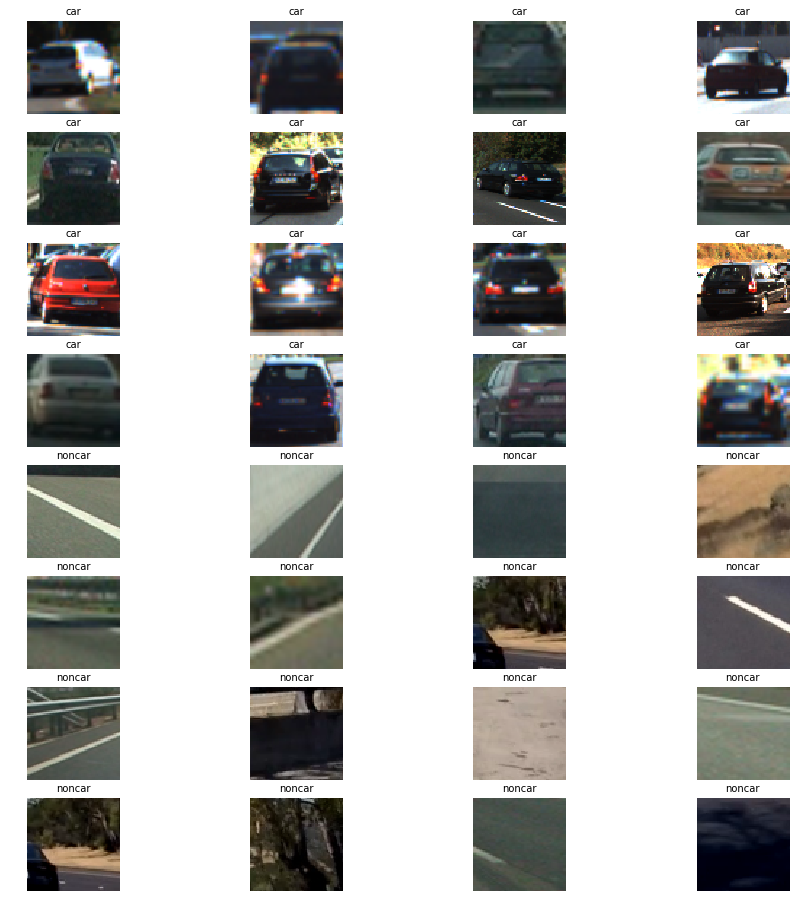

In [3]:
# print some images of cars and non card
fig, axs = plt.subplots(8,4, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in np.arange(16):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(16,32):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('noncar', fontsize=10)
    axs[i].imshow(img)

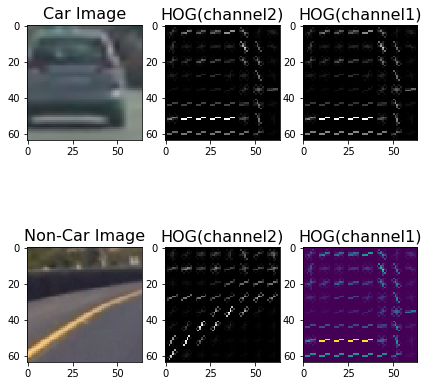

In [4]:
#extract Hog features on couple of sample images

#Run the hog feature extraction on test image
orient = 9
pix_per_cell = 8
cell_per_block = 2

car_img = mpimg.imread(car_images[6])
_, car_dst = get_hog_features(car_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, car_dst_all = get_hog_features(car_img[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[5])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, noncar_dst_all = get_hog_features(car_img[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('HOG(channel2)', fontsize=16)
ax3.imshow(car_dst_all, cmap='gray')
ax3.set_title('HOG(channel1)', fontsize=16)
ax4.imshow(noncar_img)
ax4.set_title('Non-Car Image', fontsize=16)
ax5.imshow(noncar_dst, cmap='gray')
ax5.set_title('HOG(channel2)', fontsize=16)
ax6.imshow(noncar_dst_all)
ax6.set_title('HOG(channel1)', fontsize=16)


In [13]:
#List of helper functions to run on test images

def display_hog(images):

    # Define feature parameters
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2

    for idx, img_src in enumerate(images):
        img = mpimg.imread(img_src)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        _, hog_image = get_hog_features(img[:,:,0], orient, pix_per_cell,
                                cell_per_block, vis=True, feature_vec=False)
        plt.imsave('./output_images/hog/'+str(idx+1)+'.jpg', hog_image)
        
    #display the last image for reference
    plt.imshow(hog_image,cmap='gray')
    plt.show()
        
def display_heatmap(images):

    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = (16, 16)
    hist_bins = 32
    
    ystart = 380
    ystop = 656
    scale = 1.5
    
    svc = joblib.load('classifier.pkl')
    X_scaler = pickle.load(open('scaler.p', 'rb'))

    # Iterate over test images
    for idx, img_src in enumerate(images):
        img = mpimg.imread(img_src)
        out_img, heat_map = find_cars(img, scale, ystart, ystop, pix_per_cell,
                                cell_per_block, orient, spatial_size, hist_bins,X_scaler,svc)
        heat_map = apply_threshold(heat_map, 1)   
        plt.imsave('./output_images/heatmap/'+str(idx+1)+'.jpg', heat_map)
    
    #display the last image for reference
    plt.figure(figsize=(10,10))
    plt.imshow(heat_map, cmap='hot')
    plt.show()

def display_bboxes(images):

    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = (16, 16)
    hist_bins = 32
    
    ystart = 380
    ystop = 656
    scale = 1.5
    
    svc = joblib.load('classifier.pkl')
    X_scaler = pickle.load(open('scaler.p', 'rb'))
    
    # Iterate over test images
    for idx, img_src in enumerate(images):
        img = mpimg.imread(img_src)
        out_img, heat_map = find_cars(img, scale, ystart, ystop, pix_per_cell,
                                cell_per_block, orient, spatial_size, hist_bins,X_scaler,svc)
        heat_map = apply_threshold(heat_map, 2.5)
        labels = label(heat_map)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
        plt.imsave('./output_images/output/'+str(idx+1)+'.jpg', draw_img)
    
    #display the last image for reference
    plt.figure(figsize=(10,10))
    plt.imshow(draw_img) 
    plt.show()

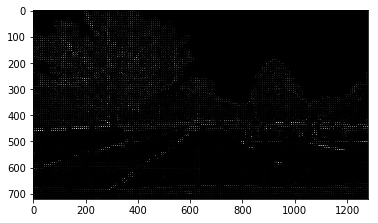

In [8]:
#run these operation on test images  
# Load list of images to show viz
test_images = glob.glob('./test_images/test*.jpg')

# Calculate hog features on test images. Output images are at /output_images/hog*
display_hog(test_images)

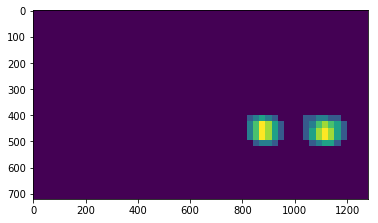

In [9]:
# Run classifier on test image and generate heatmaps
display_heatmap(test_images)

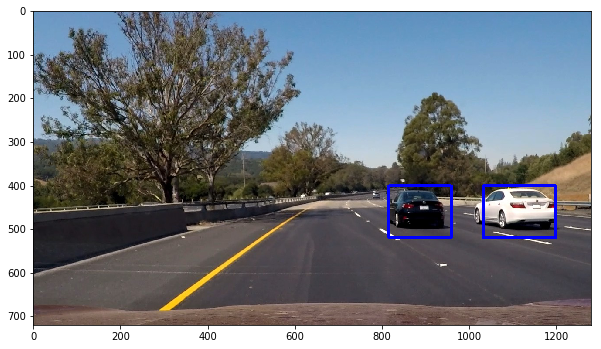

In [12]:
# Display bboxes on test images
display_bboxes(test_images)